In [1]:
import pandas as pd
import csv
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pylab as pl
import numpy as np
import statsmodels.api as sm
from pylab import rcParams
%matplotlib inline

import itertools as it
from datetime import datetime

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric, plot_forecast_component
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR
from fbprophet import Prophet

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math


import warnings
warnings.filterwarnings('ignore')

import acquire
import prepare

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Acquire Fitbit data

In [2]:
df = acquire.merge_dataframes()

In [3]:
#df.to_csv('/Users/rachelreuter/ds-methodologies/time_series/project_explore/project_data.csv')

In [4]:
df.shape

(225, 10)

In [5]:
df.head()

,date,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
1,2018-04-26,"2,635","2,931",1.38,2,"1,347",93,0,0,566
2,2018-04-27,"3,649","9,971",4.7,19,"1,158",219,46,17,"1,752"
3,2018-04-28,"3,379","3,521",1.66,2,702,155,22,11,"1,124"
4,2018-04-29,"2,851","1,639",0.77,0,891,122,0,0,602
5,2018-04-30,"2,825","1,323",0.62,0,880,104,0,0,540


In [6]:
def missing_values_col(df):
    """
    Write or use a previously written function to return the
    total missing values and the percent missing values by column.
    """
    null_count = df.isnull().sum()
    null_percentage = (null_count / df.shape[0]) * 100
    empty_count = pd.Series(((df == ' ') | (df == '')).sum())
    empty_percentage = (empty_count / df.shape[0]) * 100
    nan_count = pd.Series(((df == 'nan') | (df == 'NaN')).sum())
    nan_percentage = (nan_count / df.shape[0]) * 100
    return pd.DataFrame({'num_missing': null_count, 'missing_percentage': null_percentage,
                         'num_empty': empty_count, 'empty_percentage': empty_percentage,
                         'nan_count': nan_count, 'nan_percentage': nan_percentage})

missing_values_col(df)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
date,0,0.00,0,0.00,0,0.00
calories_burned,0,0.00,0,0.00,0,0.00
steps,0,0.00,0,0.00,0,0.00
distance,0,0.00,0,0.00,0,0.00
floors,0,0.00,0,0.00,0,0.00
minutes_sedentary,0,0.00,0,0.00,0,0.00
minutes_lightly_active,0,0.00,0,0.00,0,0.00
minutes_fairly_active,0,0.00,0,0.00,0,0.00
minutes_very_active,0,0.00,0,0.00,0,0.00
activity_calories,0,0.00,0,0.00,0,0.00


# Prepare

In [7]:
df = prepare.update_dtypes(df)

In [8]:
df.dtypes

calories_burned             int64
steps                       int64
distance                  float64
 floors                     int64
minutes_sedentary           int64
minutes_lightly_active      int64
minutes_fairly_active       int64
minutes_very_active         int64
activity_calories           int64
dtype: object

# Exploration

In [9]:
df[df.steps <= 500].shape

(17, 9)

In [10]:
#df[df.minutes_sedentary >= 1440]

In [11]:
#df.sort_values('steps',ascending=True)

In [12]:
df.describe()

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
count,225.00,225.00,225.00,225.00,225.00,225.00,225.00,225.00,225.00
mean,"3,401.91","8,536.19",4.05,12.59,809.52,188.24,14.92,33.87,"1,484.55"
std,632.43,"5,255.75",2.51,25.84,243.23,75.17,15.36,37.20,747.80
min,799.00,0.00,0.00,0.00,28.00,0.00,0.00,0.00,0.00
25%,"3,069.00","4,714.00",2.22,2.00,654.00,158.00,3.00,2.00,"1,062.00"
50%,"3,385.00","7,806.00",3.68,7.00,750.00,203.00,11.00,15.00,"1,481.00"
75%,"3,765.00","12,380.00",5.90,13.00,877.00,236.00,21.00,63.00,"1,962.00"
max,"5,199.00","25,512.00",12.00,195.00,"1,440.00",349.00,78.00,154.00,"3,596.00"


In [13]:
df.shape

(225, 9)

In [14]:
df['min_active'] = df.minutes_lightly_active + df.minutes_fairly_active + df.minutes_very_active

In [51]:
df.tail()

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,min_active
date,,,,,,,,,,
2018-12-02,3957,13257,6.23,195,725,265,13,70,2305,348
2018-12-03,3660,12915,6.12,6,782,219,40,51,1993,310
2018-12-04,3384,13763,6.49,13,608,199,11,67,1663,277
2018-12-05,3670,13865,6.52,12,739,200,12,69,1968,281
2018-12-06,3669,14774,6.96,9,647,198,4,78,1962,280


In [16]:
# activity_daily_ratio = df.min_active / 1440
# activity_daily_ratio

In [17]:
# activity_vs_sed_ratio = df.min_active / df.minutes_sedentary
# activity_vs_sed_ratio

In [18]:
# act_vs_all_cals = df.activity_calories / df.calories_burned
# act_vs_all_cals

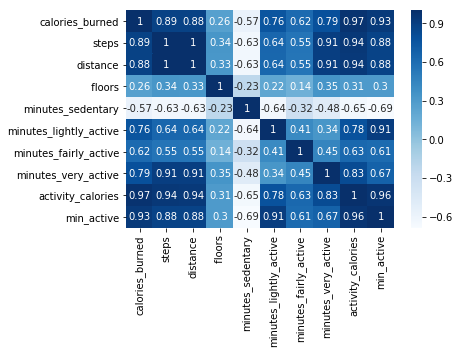

In [19]:
sns.heatmap(df.corr(), cmap='Blues', annot=True)

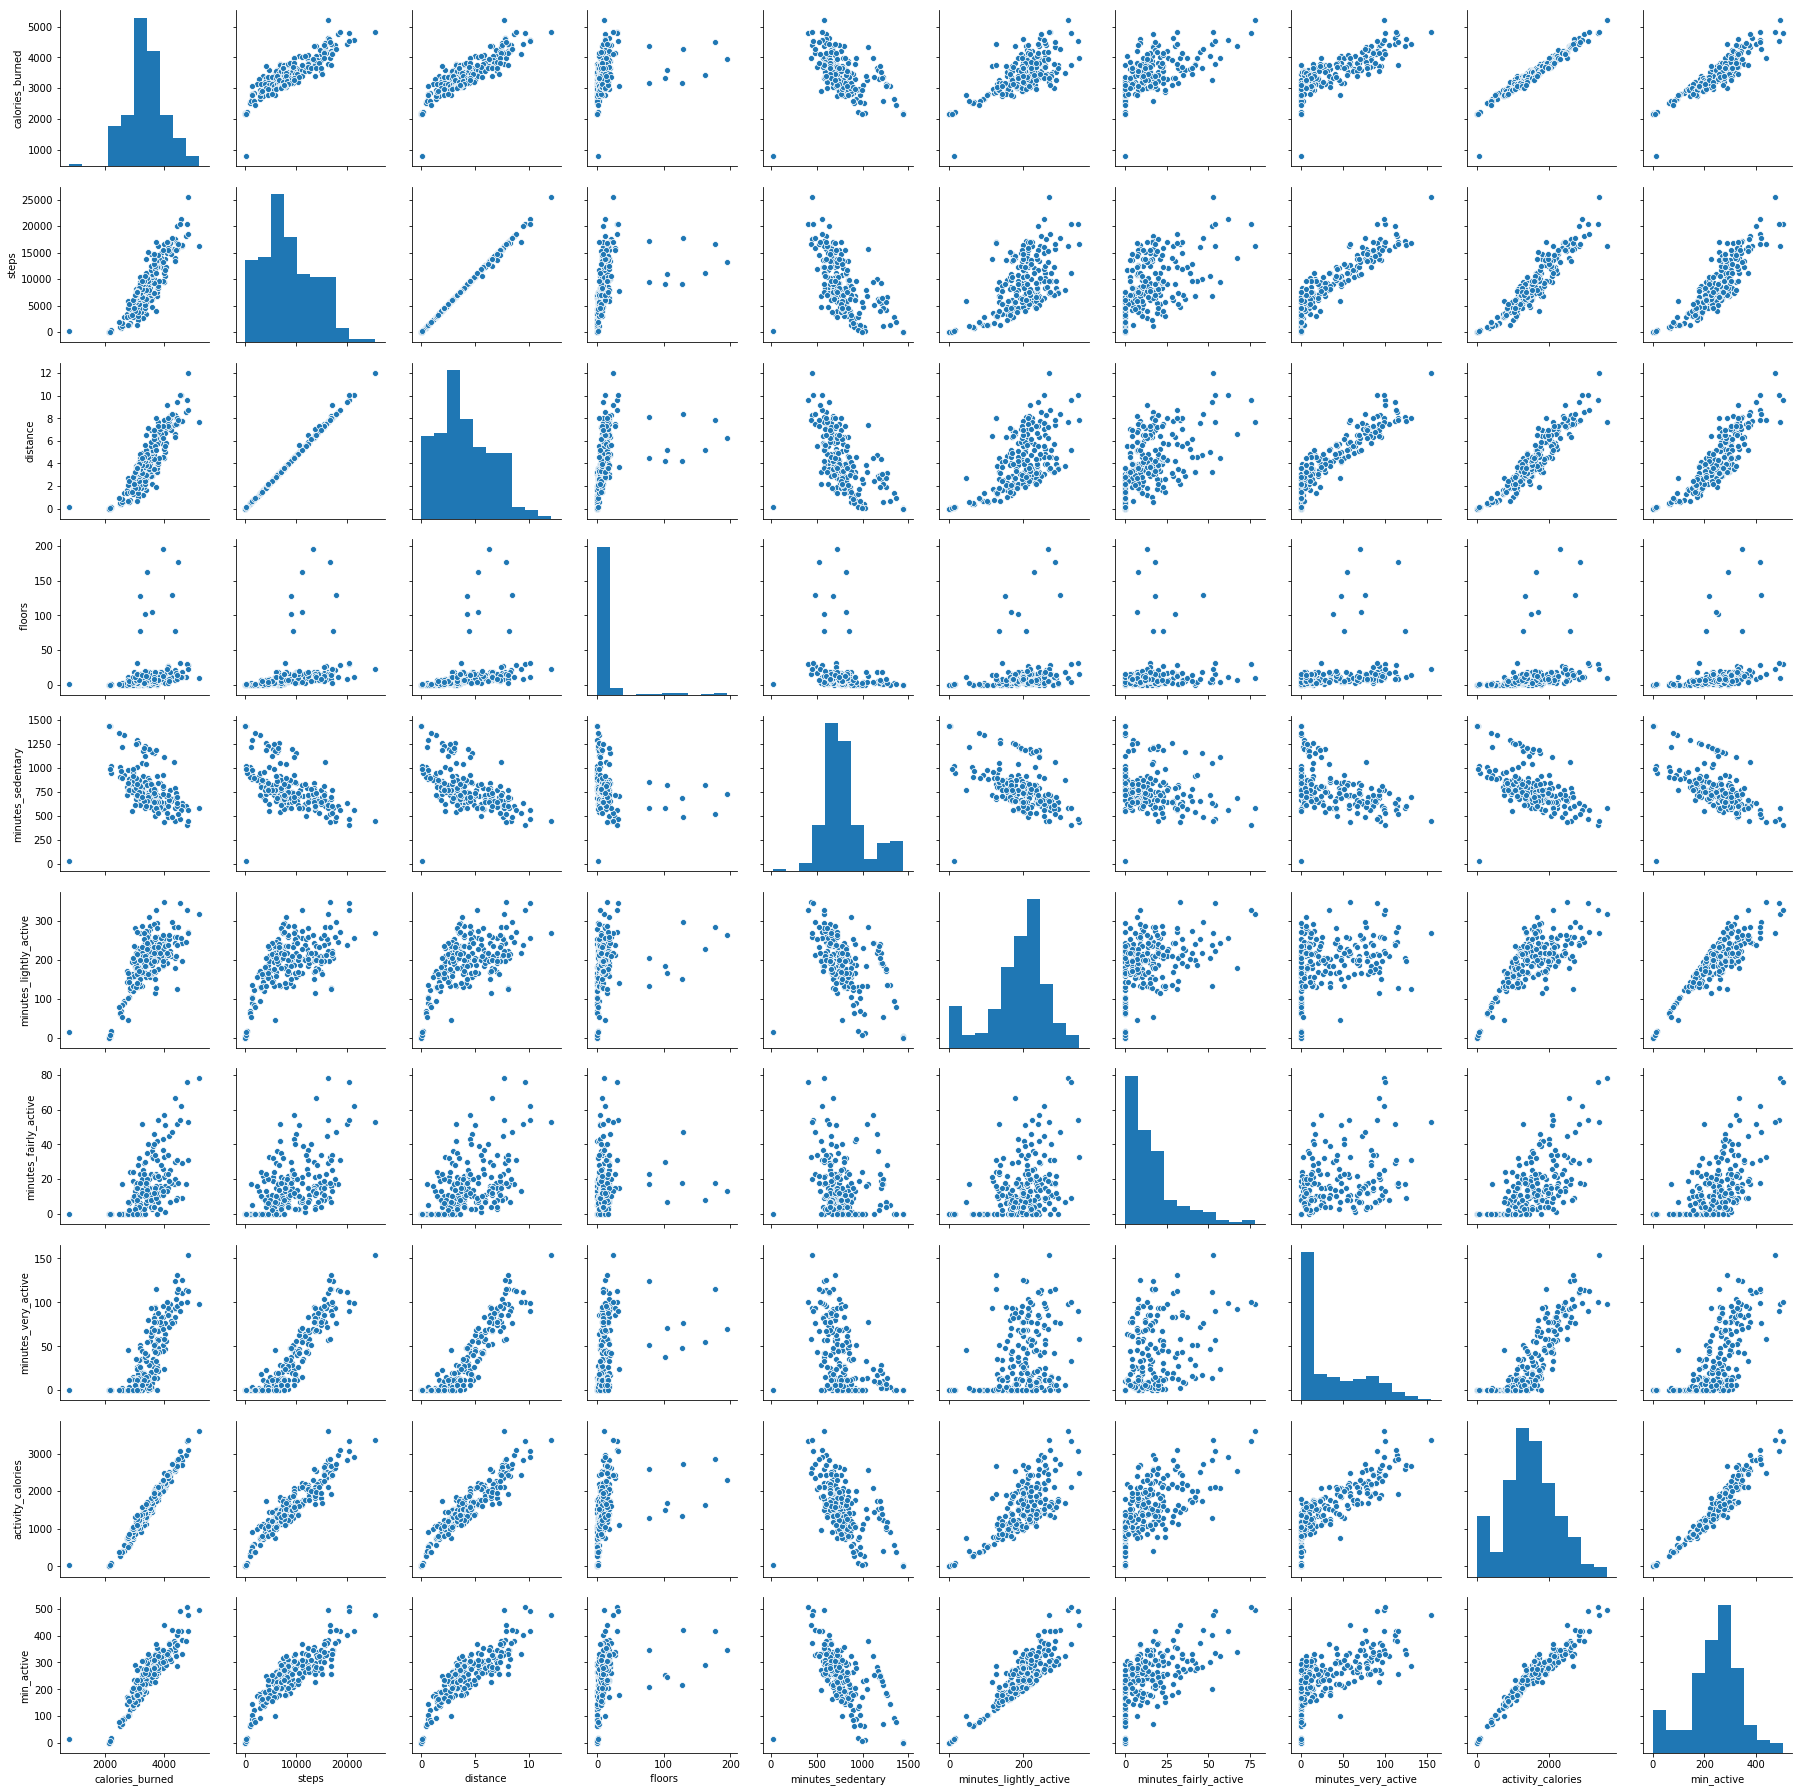

In [20]:
sns.pairplot(df)

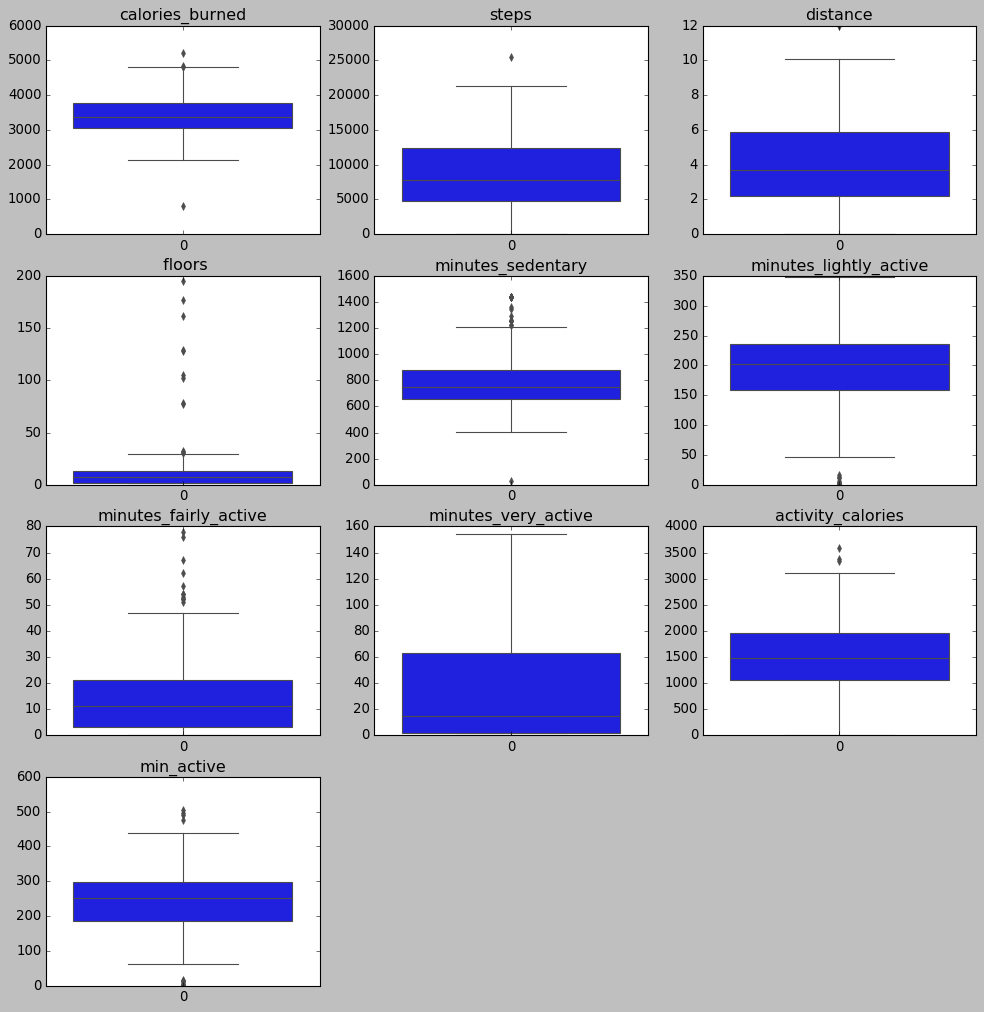

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('classic')


plt.figure(figsize=(15, 15))

for i, col in enumerate(['calories_burned', 'steps', 'distance', ' floors', 'minutes_sedentary','minutes_lightly_active', 'minutes_fairly_active', 'minutes_very_active','activity_calories','min_active']):
    plot_number = i + 1 # i starts at 0, but plot nos should start at 1
    series = df[col]
    plt.subplot(4, 3, plot_number)
    plt.title(col)
    sns.boxplot(data=series)

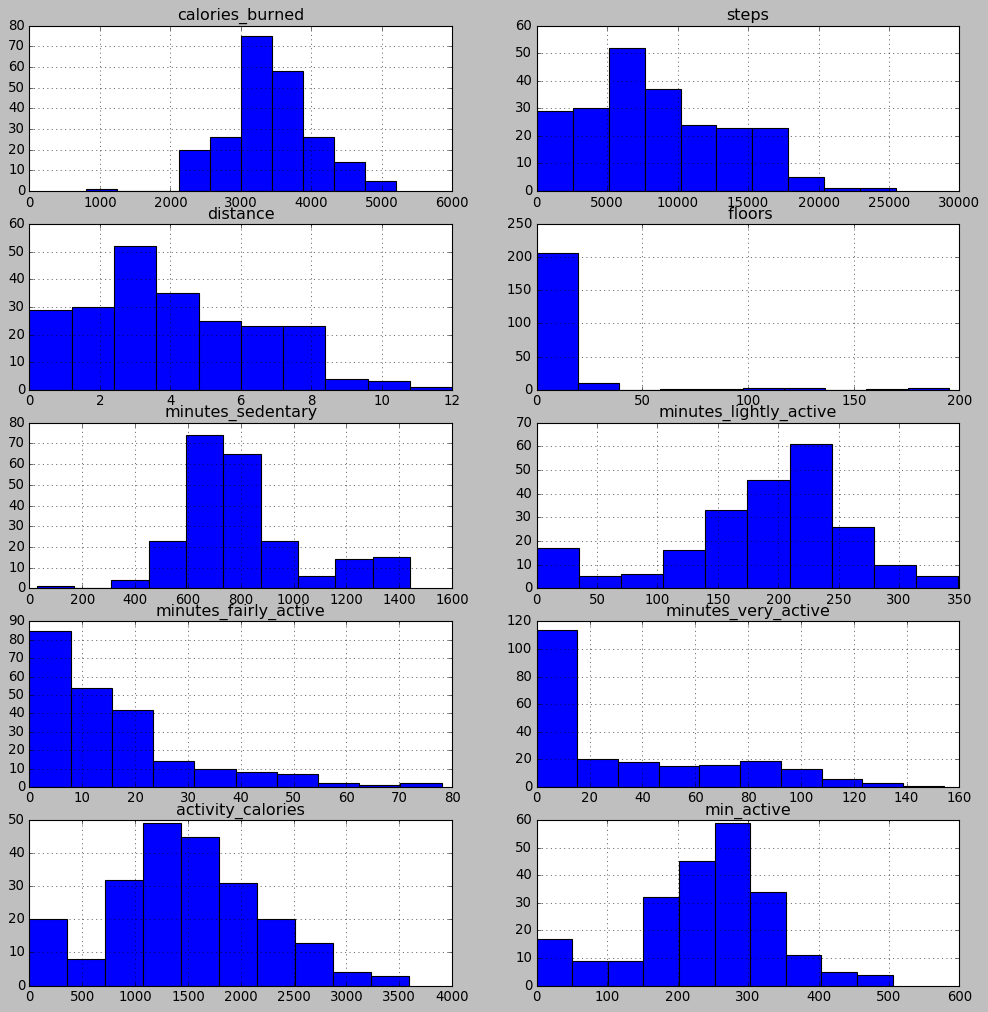

In [22]:
plt.figure(figsize=(15, 15))
for i, col in enumerate(['calories_burned', 'steps', 'distance', ' floors', 'minutes_sedentary','minutes_lightly_active', 'minutes_fairly_active', 'minutes_very_active','activity_calories','min_active']):
    plot_number = i + 1  # i starts at 0, but plot nos should start at 1
    series = df[col]
    plt.subplot(5, 2, plot_number)
    plt.title(col)
    series.hist(density=False, cumulative=False, log=False)

In [23]:
df.isna().sum()

calories_burned           0
steps                     0
distance                  0
 floors                   0
minutes_sedentary         0
minutes_lightly_active    0
minutes_fairly_active     0
minutes_very_active       0
activity_calories         0
min_active                0
dtype: int64

In [24]:
train = df[:'2018-10-31']
test = df['2018-11-01':]
print('\nTRAIN:')
print(train.nunique())
print('\nTEST:')
print(test.nunique())


TRAIN:
calories_burned           172
steps                     177
distance                  158
 floors                    30
minutes_sedentary         153
minutes_lightly_active    119
minutes_fairly_active      49
minutes_very_active        75
activity_calories         172
min_active                141
dtype: int64

TEST:
calories_burned           36
steps                     36
distance                  35
 floors                   24
minutes_sedentary         34
minutes_lightly_active    30
minutes_fairly_active     23
minutes_very_active       29
activity_calories         36
min_active                35
dtype: int64


In [25]:
print('\ntrain shape:')
train.shape


train shape:


(189, 10)

In [26]:
print('\ntest shape:')
test.shape


test shape:


(36, 10)

In [27]:
cals = train.resample('D').calories_burned.mean()

In [28]:
cals.head()

date
2018-04-26    2635
2018-04-27    3649
2018-04-28    3379
2018-04-29    2851
2018-04-30    2825
Freq: D, Name: calories_burned, dtype: int64

In [83]:
steps_df = train.resample('D').steps.mean()

Text(0.5, 1.0, 'Daily Steps')

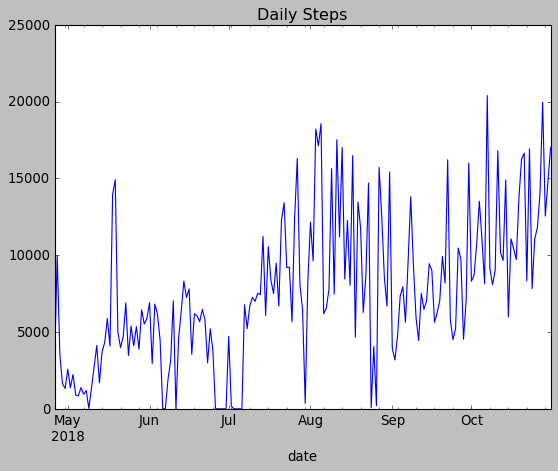

In [84]:
steps_df.plot()
plt.title('Daily Steps')

Text(0.5, 1.0, 'Daily Calories Burned')

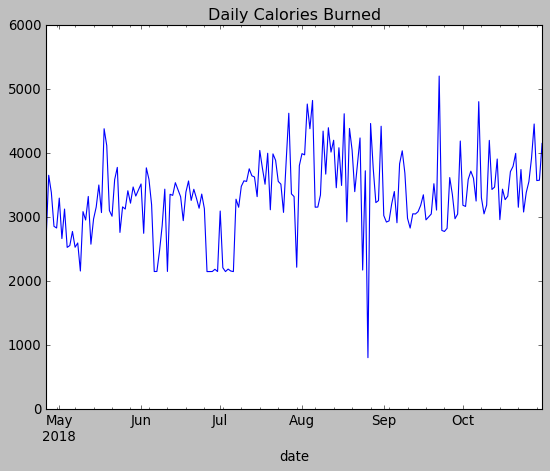

In [61]:
cals.plot()
plt.title('Daily Calories Burned')

Text(0.5, 1.0, 'Weekly Avg Calories Burned')

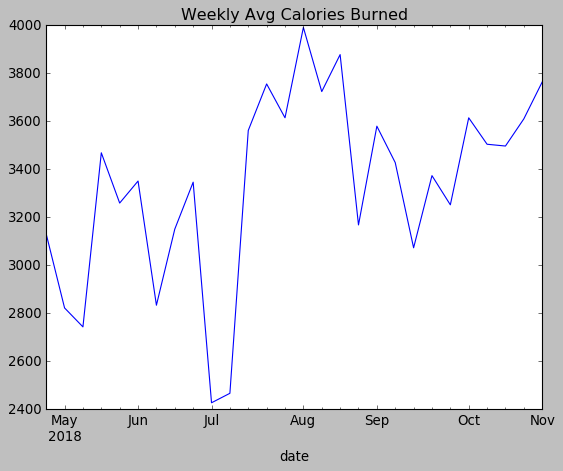

In [62]:
cals.resample('W').mean().plot()
plt.title('Weekly Avg Calories Burned')

Text(0.5, 1.0, 'Monthly Avg Calories Burned')

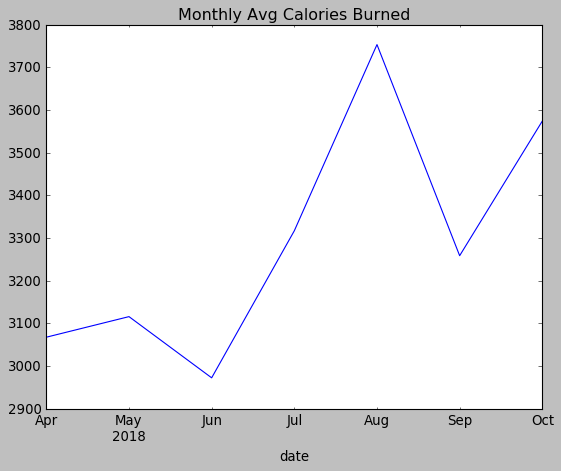

In [63]:
cals.resample('MS').mean().plot()
plt.title('Monthly Avg Calories Burned')

Text(0.5, 1.0, 'Rolling Five-Day Avg Calories Burned')

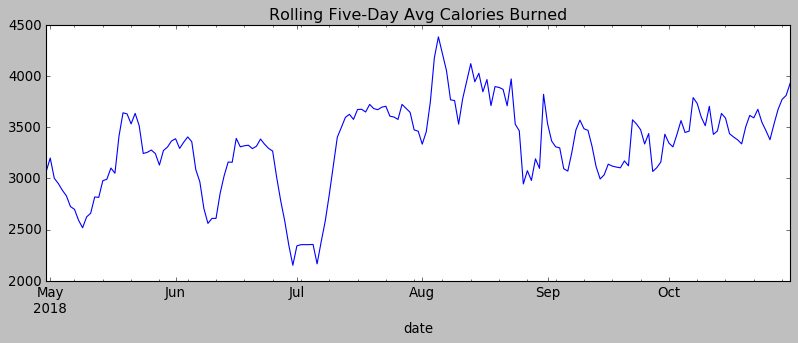

In [64]:
cals.rolling(5).mean().plot(figsize=(12,4))
plt.title('Rolling Five-Day Avg Calories Burned')

Text(0.5, 1.0, 'Ten-Period Difference in Calories Burned')

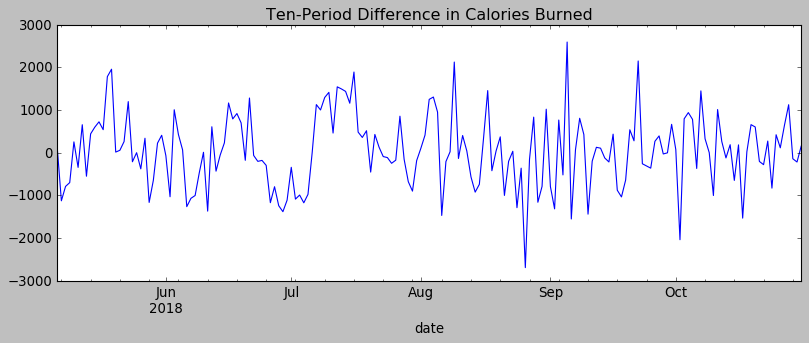

In [65]:
cals.diff(periods=10).plot(figsize=(12,4))
plt.title('Ten-Period Difference in Calories Burned')

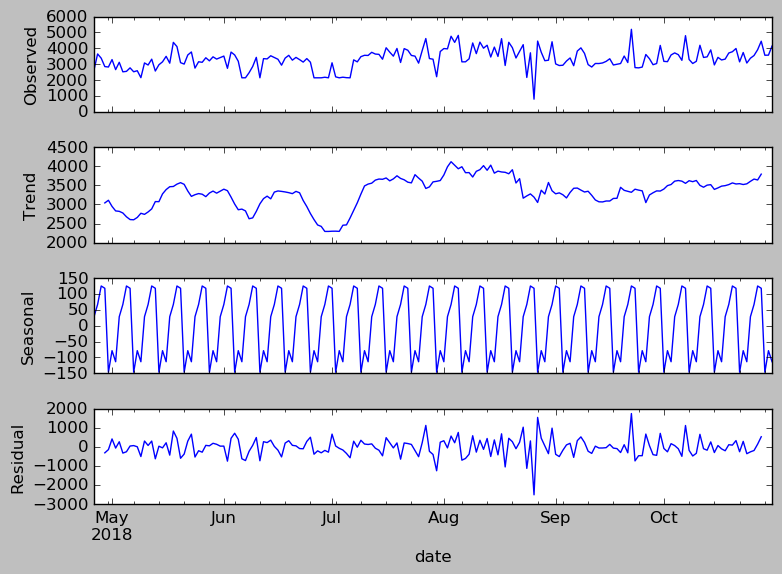

In [68]:
decomposition = sm.tsa.seasonal_decompose(cals, model='additive')
fig = decomposition.plot()
#figsize=(10,10)
fig.set_dpi(100)
plt.show()

### Plot the measure (t) on the x-axis against the calories_burned at the previous time step (t-1)

Text(0.5, 1.0, 'Calories Burned vs Calories Burned at Prev. Time Step')

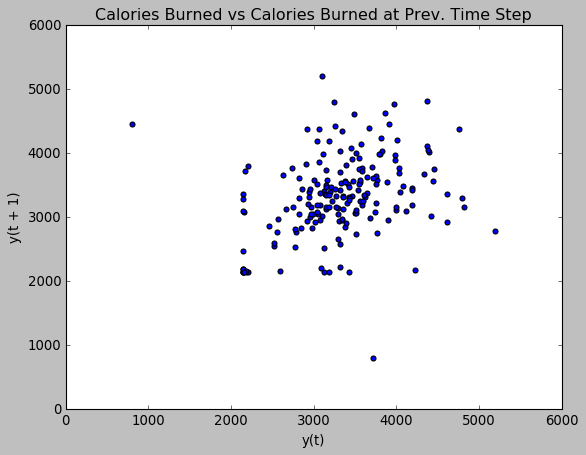

In [69]:
pd.plotting.lag_plot(cals)
plt.title('Calories Burned vs Calories Burned at Prev. Time Step')

In [36]:
df_corr = pd.concat([cals.shift(1),cals], axis=1)
df_corr.columns = ['t-1','t+1']
result = df_corr.corr()
print(result)

                     t-1                  t+1
t-1                 1.00                 0.31
t+1                 0.31                 1.00


In [37]:
df1 = df[df['calories_burned']>=1]
df1 = df1.reset_index()

#d_df = d_df[d_df['item_brand']=='Kelloggs']

In [38]:
df1.head()

,date,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,min_active
0,2018-04-26,2635,2931,1.38,2,1347,93,0,0,566,93
1,2018-04-27,3649,9971,4.70,19,1158,219,46,17,1752,282
2,2018-04-28,3379,3521,1.66,2,702,155,22,11,1124,188
3,2018-04-29,2851,1639,0.77,0,891,122,0,0,602,122
4,2018-04-30,2825,1323,0.62,0,880,104,0,0,540,104


In [39]:
df1.shape

(225, 11)

In [40]:
df1.head()

,date,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,min_active
0,2018-04-26,2635,2931,1.38,2,1347,93,0,0,566,93
1,2018-04-27,3649,9971,4.70,19,1158,219,46,17,1752,282
2,2018-04-28,3379,3521,1.66,2,702,155,22,11,1124,188
3,2018-04-29,2851,1639,0.77,0,891,122,0,0,602,122
4,2018-04-30,2825,1323,0.62,0,880,104,0,0,540,104


In [57]:
df.columns

Index(['calories_burned', 'steps', 'distance', ' floors', 'minutes_sedentary', 'minutes_lightly_active', 'minutes_fairly_active', 'minutes_very_active', 'activity_calories', 'min_active'], dtype='object')

## Prophet

In [41]:
df1['y'] = df1.calories_burned
df1['ds'] = pd.to_datetime(df1.date)
df1 = df1.groupby(['ds'])['y'].sum().reset_index()
#df1 = df1.groupby(['ds']).y.sum().asfreq('D').reset_index()

In [80]:
df1.head()

,ds,y,cap,floor
0,2018-04-26,2635,5500,100
1,2018-04-27,3649,5500,100
2,2018-04-28,3379,5500,100
3,2018-04-29,2851,5500,100
4,2018-04-30,2825,5500,100


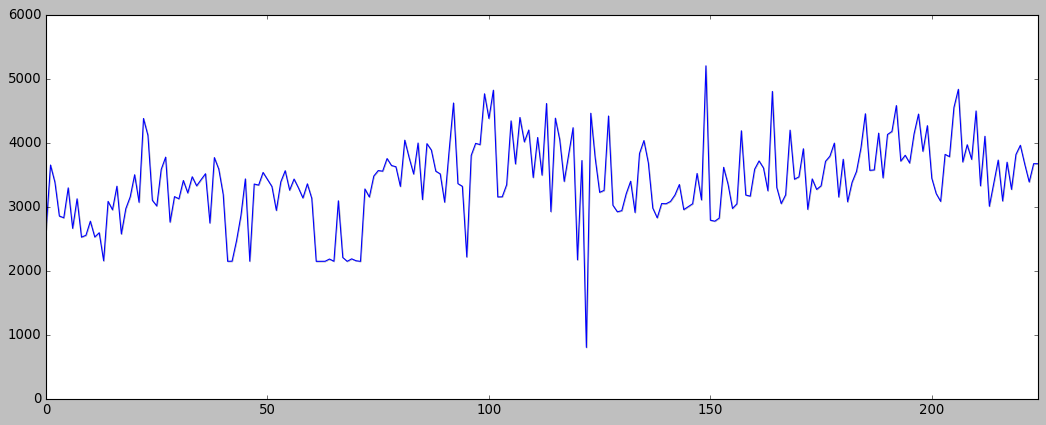

In [42]:
plt.figure(figsize=(16,6))
sns.tsplot(df1.y)

## Model

### Create an instance of the Prophet class and then fit our dataframe to it
### PROPHET using 'calories_burned' field.

In [88]:
df1['cap'] = 5500
df1['floor'] = 100
m = Prophet(daily_seasonality=True, growth='logistic', changepoint_range=0.9,yearly_seasonality=True)
m.fit(df1)

### Create a "future" dataframe

In [89]:
future = m.make_future_dataframe(periods=22)
future['cap'] = 5500
future['floor'] = 100
print(future.head())
print(future.tail())
print(df1.tail())

          ds   cap  floor
0 2018-04-26  5500    100
1 2018-04-27  5500    100
2 2018-04-28  5500    100
3 2018-04-29  5500    100
4 2018-04-30  5500    100
            ds   cap  floor
242 2018-12-24  5500    100
243 2018-12-25  5500    100
244 2018-12-26  5500    100
245 2018-12-27  5500    100
246 2018-12-28  5500    100
            ds     y   cap  floor
220 2018-12-02  3957  5500    100
221 2018-12-03  3660  5500    100
222 2018-12-04  3384  5500    100
223 2018-12-05  3670  5500    100
224 2018-12-06  3669  5500    100


### Predict
- Call predict to make a prediction and store it in the forecast dataframe.
- In that df you will see the the predictions as well as the lower and upper boundaries of the uncertainty interval.

In [107]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(22)

,ds,yhat,yhat_lower,yhat_upper
213,2018-12-07,"15,423.94","11,227.39","19,666.99"
214,2018-12-08,"16,340.44","12,341.45","20,427.91"
215,2018-12-09,"16,898.75","12,846.68","21,205.51"
216,2018-12-10,"14,823.05","10,533.07","19,036.69"
217,2018-12-11,"16,041.34","11,985.04","20,371.37"
218,2018-12-12,"16,281.16","12,001.32","20,723.68"
219,2018-12-13,"18,016.31","13,876.45","22,264.07"
220,2018-12-14,"18,473.26","14,725.62","22,822.71"
221,2018-12-15,"19,248.06","14,962.50","23,461.43"
222,2018-12-16,"19,611.60","15,686.95","23,808.85"


### Plot
- Next, plot the forecast by calling plot and passing in the forecast dataframe.
- The black dots represent outliers and the light-blue shaded regions, the uncertainty intervals.

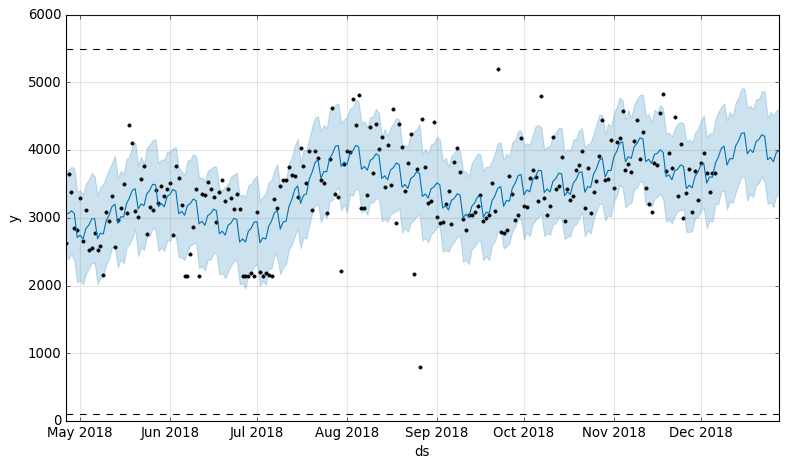

In [46]:
fig1 = m.plot(forecast)

##### We can break this down a bit further by calling the plot_components() method to inspect the forecast components.

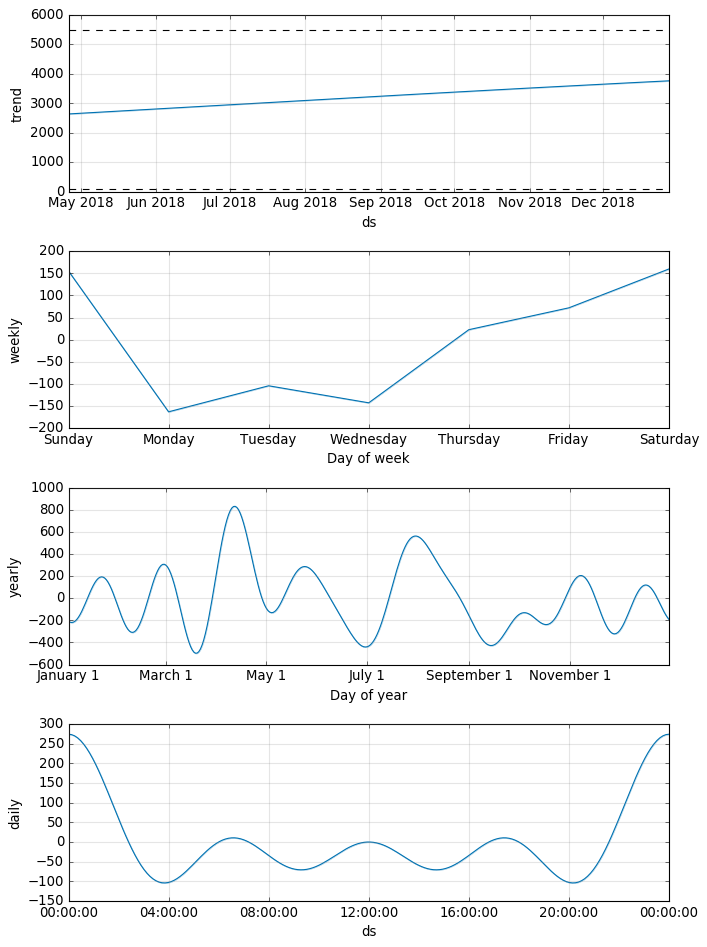

In [47]:
fig2 = m.plot_components(forecast)

### Evaluate
- Evaluate the forecast using Prophet’s cross validation procedure.

- Use the cross_validation() function on the model and specify the forecast horizon with the horizon parameter.
- Next, call performance_metrics() to get a table with various prediction performance metrics.

In [ ]:
from fbprophet.diagnostics import cross_validation, performance_metrics
# cross_validation(m, initial = 730, period = 180, horizon = 365, units = 'days')
df_cv = cross_validation(m, horizon='22 days')

df_p = performance_metrics(df_cv)

In [71]:
df_p.tail(22)

INFO:fbprophet:Making 13 forecasts with cutoffs between 2018-07-05 00:00:00 and 2018-11-14 00:00:00


,horizon,mse,rmse,mae,mape,coverage
284,21 days,"7,990,762.93","2,826.79","1,830.36",0.80,0.43
240,21 days,"6,968,514.23","2,639.79","1,670.17",0.74,0.43
42,21 days,"7,082,473.63","2,661.29","1,728.59",0.76,0.39
152,21 days,"5,615,963.05","2,369.80","1,595.91",0.46,0.39
218,21 days,"5,620,089.34","2,370.67","1,598.88",0.46,0.36
64,21 days,"4,589,086.17","2,142.22","1,431.58",0.40,0.36
108,21 days,"5,562,524.67","2,358.50","1,529.52",0.42,0.36
174,21 days,"6,258,035.80","2,501.61","1,665.38",0.45,0.32
86,21 days,"6,741,473.46","2,596.43","1,766.69",0.48,0.32
153,22 days,"7,393,512.41","2,719.10","1,889.82",0.52,0.32


- We can also plot the mean absolute percent error (MAPE) over the forecast horizon to determine how trustworthy our forecast is.
- Here, we use a percentage error instead of the mean squared error (MSE) simply because it is easier to interpret.

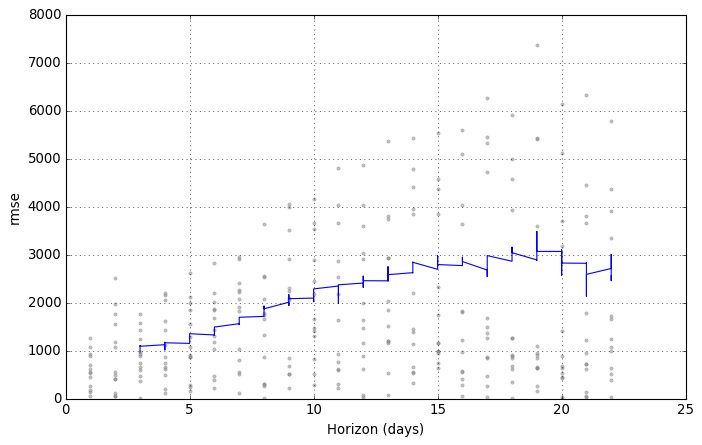

In [49]:
# plot_forecast_component(m, forecast, 'yhat')
fig3 = plot_cross_validation_metric(df_cv, metric='rmse')

#Prophet-Calories_burned done

### Second Prophet model on different field

In [97]:
df2 = df[df['steps']>=1]
df2 = df2.reset_index()

In [98]:
df2['y'] = df2.steps
df2['ds'] = pd.to_datetime(df2.date)
df2 = df2.groupby(['ds'])['y'].sum().reset_index()
#df1 = df1.groupby(['ds']).y.sum().asfreq('D').reset_index()

In [99]:
df2.head()

,ds,y
0,2018-04-26,2931
1,2018-04-27,9971
2,2018-04-28,3521
3,2018-04-29,1639
4,2018-04-30,1323


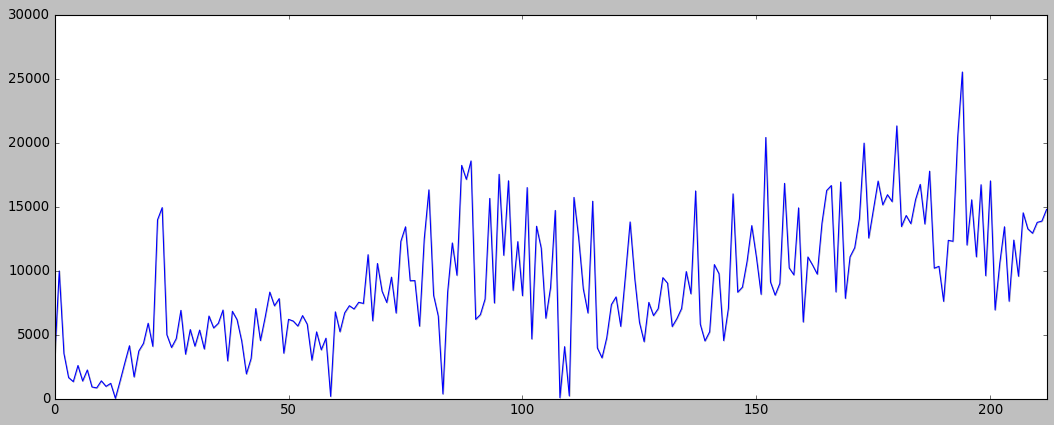

In [100]:
plt.figure(figsize=(16,6))
sns.tsplot(df2.y)

## Model

### Create an instance of the Prophet class and then fit our dataframe to it
### PROPHET using 'steps' field.

In [102]:
df2['cap'] = 25000
df2['floor'] = 100
m = Prophet(daily_seasonality=True, growth='logistic', changepoint_range=0.9,yearly_seasonality=True)
m.fit(df2)

### Create a "future" dataframe

In [103]:
future = m.make_future_dataframe(periods=22)
future['cap'] = 25000
future['floor'] = 100
print(future.head())
print(future.tail())
print(df2.tail())

          ds    cap  floor
0 2018-04-26  25000    100
1 2018-04-27  25000    100
2 2018-04-28  25000    100
3 2018-04-29  25000    100
4 2018-04-30  25000    100
            ds    cap  floor
230 2018-12-24  25000    100
231 2018-12-25  25000    100
232 2018-12-26  25000    100
233 2018-12-27  25000    100
234 2018-12-28  25000    100
            ds      y    cap  floor
208 2018-12-02  13257  25000    100
209 2018-12-03  12915  25000    100
210 2018-12-04  13763  25000    100
211 2018-12-05  13865  25000    100
212 2018-12-06  14774  25000    100


### Predict
- Call predict to make a prediction and store it in the forecast dataframe.
- In that df you will see the the predictions as well as the lower and upper boundaries of the uncertainty interval.

In [108]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(58)

,ds,yhat,yhat_lower,yhat_upper
177,2018-11-01,"15,470.35","11,432.85","19,895.18"
178,2018-11-02,"15,734.64","11,638.09","19,930.92"
179,2018-11-03,"16,333.67","12,157.17","20,370.89"
180,2018-11-04,"16,540.01","12,142.32","20,637.06"
181,2018-11-05,"14,083.38","9,951.83","18,400.09"
182,2018-11-06,"14,897.84","10,572.11","18,758.72"
183,2018-11-07,"14,717.45","10,421.66","18,993.31"
184,2018-11-08,"16,022.85","11,983.13","20,319.31"
185,2018-11-09,"16,047.51","12,004.73","20,447.86"
186,2018-11-10,"16,394.58","12,222.33","21,003.20"


In [117]:
df.tail(2)

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,min_active
date,,,,,,,,,,
2018-12-05,3670,13865,6.52,12,739,200,12,69,1968,281
2018-12-06,3669,14774,6.96,9,647,198,4,78,1962,280


### Plot
- Next, plot the forecast by calling plot and passing in the forecast dataframe.
- The black dots represent outliers and the light-blue shaded regions, the uncertainty intervals.

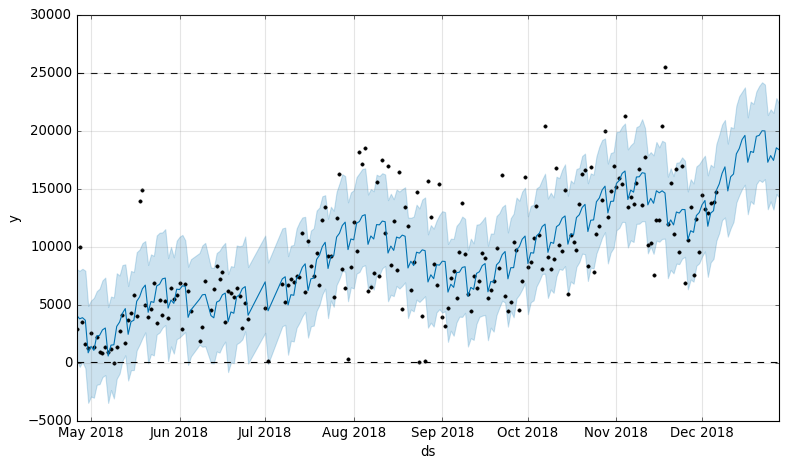

In [110]:
fig1 = m.plot(forecast)

##### We can break this down a bit further by calling the plot_components() method to inspect the forecast components.

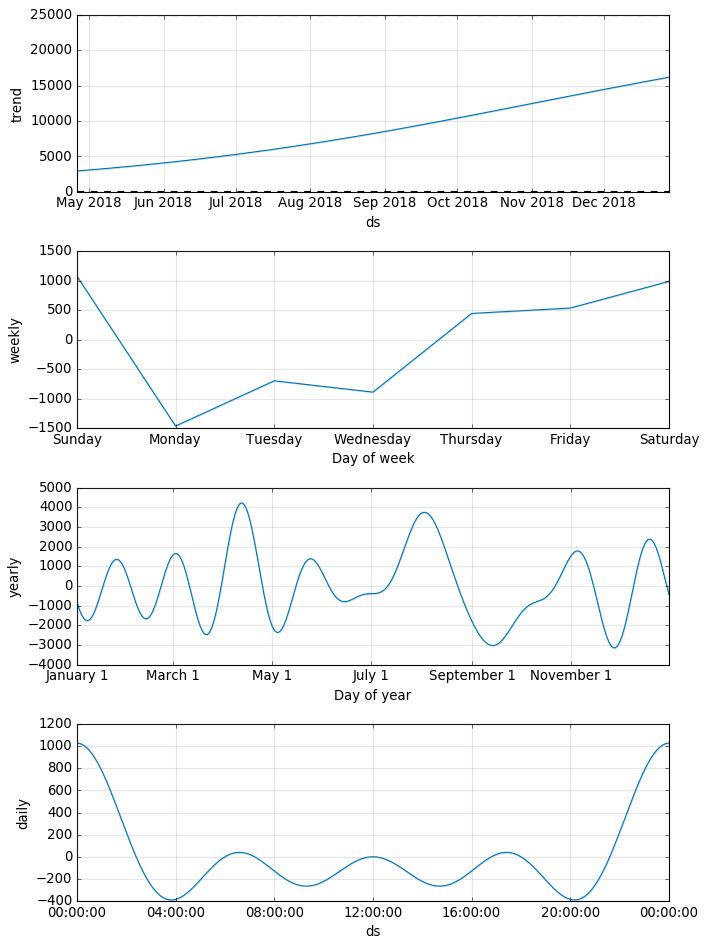

In [111]:
fig2 = m.plot_components(forecast)

### Evaluate
- Evaluate the forecast using Prophet’s cross validation procedure.

- Use the cross_validation() function on the model and specify the forecast horizon with the horizon parameter.
- Next, call performance_metrics() to get a table with various prediction performance metrics.

In [112]:
from fbprophet.diagnostics import cross_validation, performance_metrics
# cross_validation(m, initial = 730, period = 180, horizon = 365, units = 'days')
df_cv = cross_validation(m, horizon='22 days')

df_p = performance_metrics(df_cv)

INFO:fbprophet:Making 13 forecasts with cutoffs between 2018-07-05 00:00:00 and 2018-11-14 00:00:00


In [113]:
df_p.tail(22)

,horizon,mse,rmse,mae,mape,coverage
129,21 days,"161,933,474.08","12,725.31","8,316.82",4.37,0.39
261,21 days,"147,352,331.91","12,138.88","7,615.62",0.89,0.43
217,21 days,"146,651,196.36","12,109.96","7,529.10",0.88,0.46
283,21 days,"147,771,254.70","12,156.12","7,622.10",0.87,0.46
63,21 days,"147,881,505.59","12,160.65","7,665.12",0.87,0.46
239,21 days,"149,164,642.87","12,213.30","7,790.74",0.88,0.43
151,21 days,"115,458,302.55","10,745.15","6,835.09",0.70,0.46
85,21 days,"114,915,815.74","10,719.88","6,791.71",0.69,0.46
173,21 days,"115,389,864.62","10,741.97","6,876.61",0.69,0.46
130,22 days,"115,496,185.07","10,746.92","6,911.56",0.69,0.46


- We can also plot the mean absolute percent error (MAPE) over the forecast horizon to determine how trustworthy our forecast is.
- Here, we use a percentage error instead of the mean squared error (MSE) simply because it is easier to interpret.

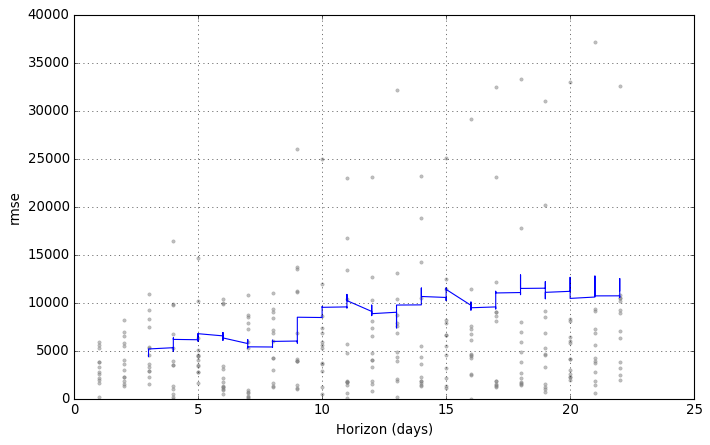

In [114]:
# plot_forecast_component(m, forecast, 'yhat')
fig3 = plot_cross_validation_metric(df_cv, metric='rmse')

#Prophet done